# Model skill assessment for regression

FMSkill is a general purpose model skill assessment library for (spatio)/temporal data.

In [17]:
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

To illustrate the functionality we will use synthetic data.

In [11]:
X, y = make_regression(n_samples=10000, n_features=10, n_informative=5, random_state=0, noise=1.0)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr =lr_model.predict(X_test)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [20]:
df = pd.DataFrame({'true':y_test, 'linear' : y_pred_lr, 'rf' : y_pred_rf})

# add a datetime index
df.index = pd.date_range('2019-01-01', periods=len(df), freq='H')
df.head()

,true,linear,rf
2019-01-01 00:00:00,63.639703,63.203949,91.337533
2019-01-01 01:00:00,-49.504154,-49.788292,-0.873369
2019-01-01 02:00:00,-170.478804,-170.834485,-160.823986
2019-01-01 03:00:00,8.617884,9.594942,27.440038
2019-01-01 04:00:00,22.772194,22.587063,26.508946


In [21]:
import fmskill

cmp = fmskill.from_matched(df, obs_item='true') # TODO add quantity 
cmp

<Comparer>
Observation: true, n_points=2500
 Model: linear, rmse=0.504
 Model: rf, rmse=24.354

In [22]:
cmp.sel(model='linear').scatter()

IndexError: index 21 is out of bounds for axis 0 with size 21

<AxesSubplot: title={'center': 'rf vs true'}, xlabel='Observation, Undefined', ylabel='Model, Undefined'>

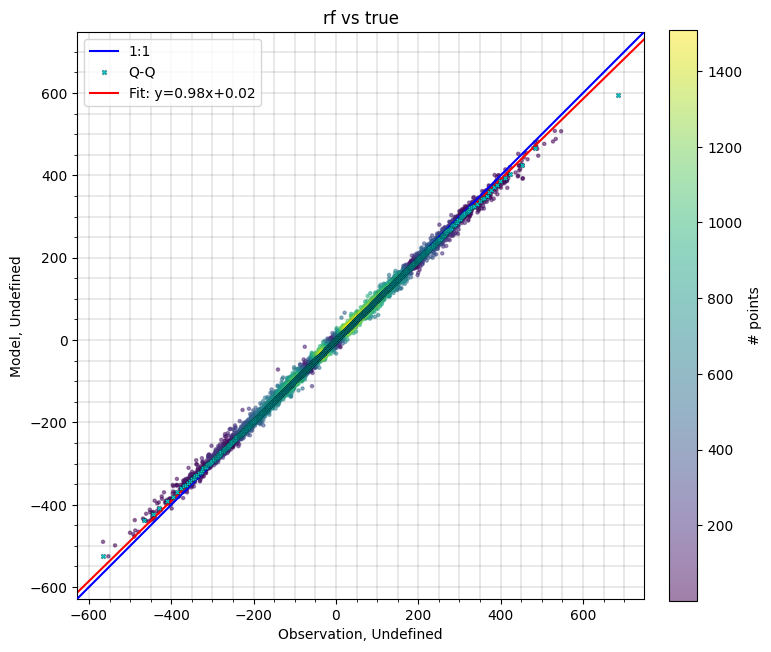

In [16]:
cmp.sel(model='rf').scatter()

In [23]:
cmp.skill()

,observation,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,,
linear,true,2500,0.015098,0.503971,0.503745,0.402738,0.999994,0.004174,0.999989
rf,true,2500,0.717956,24.353940,24.343355,16.910843,0.988206,0.201709,0.974274


In [24]:
cmp.plot_timeseries(backend="plotly")